In [1]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from pandas import concat
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq.torchdiffeq import odeint
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, 4).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = ['week(t-4)', 'week(t-3)', 'week(t-2)', 'week(t-1)', 'week(t)']).head(20))

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(502, 5)
    week(t-4)  week(t-3)  week(t-2)  week(t-1)   week(t)
0    6.522572   6.432569   6.384427   6.225123  5.997283
1    6.432569   6.384427   6.225123   5.997283  6.049106
2    6.384427   6.225123   5.997283   6.049106  6.187098
3    6.225123   5.997283   6.049106   6.187098  6.240301
4    5.997283   6.049106   6.187098   6.240301  6.642778
5    6.049106   6.187098   6.240301   6.642778  6.888709
6    6.187098   6.240301   6.642778   6.888709  6.890396
7    6.240301   6.642778   6.888709   6.890396  7.080826
8    6.642778   6.888709   6.890396   7.080826  7.292260
9    6.888709   6.890396   7.080826   7.292260  7.421818
10   6.890396   7.080826   7.292260   7.421818  7.603969
11   7.08082

In [2]:
# size of the data
data_size = data_m1.shape[0]
dim_input = data_m1.shape[1]
# batch time and batch size
batch_time = 6  # time steps ahead that we need to predict, for each training sample
batch_time2 = 6  # time steps ahead that we need to extapolate, for each test sample
train_size = int(0.8*data_size)  # training size
print(f"training size is {train_size}")
test_size = data_size - train_size
print(f"test size is {test_size}")
niters = 4000  # training epochs
test_freq = 50
viz = True

training size is 401
test size is 101


In [3]:
# Convert to tensor
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
data_torch = torch.from_numpy(data_m1)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
print(data_torch.shape)
# Reshape it to get in (m, 1, dim_input)
# data_torch = torch.reshape(data_torch, (data_size, 1, dim_input))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
# print(data_torch.shape)

# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., test_size-batch_time2, test_size-batch_time2)
print(t.shape)


torch.Size([502, 5])
torch.Size([95])


In [4]:
s = torch.arange(0, train_size-batch_time) 
torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=1).shape

torch.Size([395, 6, 5])

In [5]:
torch.arange(train_size, data_size-batch_time-3)

tensor([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
        485, 486, 487, 488, 489, 490, 491, 492])

In [6]:
s = torch.arange(train_size, data_size-batch_time)
torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=1).shape

torch.Size([95, 6, 5])

In [7]:
for i in range(-batch_time+1, batch_time2):
    print(i)

-5
-4
-3
-2
-1
0
1
2
3
4
5


In [8]:
torch.stack([data_torch[s + i] for i in range(-batch_time+1, batch_time2)], dim=1)[:, :6, :].shape

torch.Size([95, 6, 5])

In [9]:
torch.stack([data_torch[s + i] for i in range(-batch_time+1, batch_time2)], dim=1)[:, 6:, :].shape

torch.Size([95, 5, 5])

In [10]:
def get_batch(mode):
    if mode == 'train':
        # Get mini batches
        s = torch.arange(0, train_size-batch_time)  # https://pytorch.org/docs/stable/generated/torch.arange.html
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=1)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
        return batch_y0, batch_t, batch_y  # batch_y0, 
    elif mode == 'test':
        s = torch.arange(test_size, data_size-batch_time)
        # Get the #s initial values from data 
        # batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
        # The time steps ahead for each sample
        batch_t = t[:batch_time+batch_time2-1]  # (T)
        # For each initial value, we will have T values 
        batch_y = torch.stack([data_torch[s + i] for i in range(-batch_time+1, batch_time2)], dim=1)  # (T, M, D)
        # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
        test_batch_y = batch_y[:, :batch_time, :]
        label_batch_y = batch_y[:, batch_time:, :]
        return batch_t, test_batch_y, label_batch_y

In [11]:
train_batch_y0, train_batch_t, train_batch_y = get_batch('train')
print(train_batch_y0.shape)
print(train_batch_t.shape)
print(train_batch_y.shape)

torch.Size([395, 5])
torch.Size([6])
torch.Size([395, 6, 5])


In [12]:
test_batch_t, test_batch_y, label_batch_y = get_batch('test')
print(test_batch_t.shape)
print(test_batch_y.shape)
print(label_batch_y.shape)

torch.Size([11])
torch.Size([395, 6, 5])
torch.Size([395, 5, 5])


In [13]:
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 5
noise_std = .3


In [14]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.i2h = self.i2h.float()
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        self.h2o = self.h2o.float()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined.float()))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=5, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [15]:
def train(loss_str, all_values = True, niters = niters):
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)  # (train_size-batch_time, rnn_hidden)
        for t_r in reversed(range(train_batch_y.size(1))):
            obs = train_batch_y[:, t_r, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
        pred_x = dec(pred_z)

        # compute loss

        if loss_str == 'mse':
            if all_values:
                loss = torch.nn.MSELoss()(pred_x.float(), train_batch_y.float()).float()
            else:
                loss = torch.nn.MSELoss()(pred_x[:, batch_time-1, :].float(), train_batch_y[:, batch_time-1, :].float()).float()
        elif loss_str == 'elbo':
            noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
            noise_logvar = 2. * torch.log(noise_std_).to(device)
            logpx = log_normal_pdf(
                train_batch_y, pred_x, noise_logvar).sum(-1).sum(-1)
            pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
            analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                    pz0_mean, pz0_logvar).sum(-1)
            loss = torch.mean(-logpx + analytic_kl, dim=0)

        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())
        if itr%200==0:
            print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))

def train_loss():
    h = rec.initHidden().to(device)

    for t_r in reversed(range(train_batch_y.size(1))):
        obs = train_batch_y[:, t_r, :]
        out, h = rec.forward(obs, h)
    obs = train_batch_y0
    out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
    train_pred_y = dec(pred_z)
    # print(train_pred_y.shape)
    loss = torch.nn.MSELoss()(train_pred_y[:, 5, :], train_batch_y[:, 5, :])
    with torch.no_grad():
        print('Total Train Loss {:.6f}'.format(loss.item()))
    return train_batch_y, train_pred_y

def plot_train(i, train_batch_y, train_pred_y):
    t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
    plt.figure()
    plt.plot(t.numpy(), train_batch_y.numpy()[:, batch_time-1, i], 'g', label = f"orig_week{i+batch_time}")
    plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, batch_time-1, i], '--', label = f"pred_week{i+batch_time}")
    plt.title(f"Apple's Median Stock price for week{i+batch_time}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()


In [16]:
def test_loss():
    h = rec.initHidden().to(device)
    # print(h.shape)
    for t_r in reversed(range(test_batch_y.size(1))):
        obs = test_batch_y[:, t_r, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, test_batch_t).permute(1, 0, 2)
    test_pred_y = dec(pred_z)[:, batch_time:, :]
    # print(test_pred_y.shape)
    loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, batch_time2-2, :], label_batch_y[train_size-test_size:, batch_time2-2, :])
    with torch.no_grad():
        print('Total Loss {:.6f}'.format(loss.item()))
    return label_batch_y, test_pred_y


In [18]:
def plot_test(i, label_batch_y, test_pred_y):
    t = torch.linspace(1., test_size-batch_time2, test_size-batch_time2)
    plt.figure()
    plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, batch_time2-2, i], 'g', label = f"orig_week{i+batch_time}")
    plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, batch_time2-2, i], '--', label = f"pred_week{i+batch_time}")
    plt.title(f"Apple's Median Stock price for week{i+batch_time}")
    plt.legend(framealpha=1, frameon=True);
    plt.show()


In [29]:
# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, train_size-batch_time).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
lr = 0.001
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t_r in reversed(range(train_batch_y.size(1))):
        obs = train_batch_y[:, t_r, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # compute loss
#     noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
#     noise_logvar = 2. * torch.log(noise_std_).to(device)
#     logpx = log_normal_pdf(
#         train_batch_y, pred_x, noise_logvar).sum(-1).sum(-1)
#     pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
#     analytic_kl = normal_kl(qz0_mean, qz0_logvar,
#                             pz0_mean, pz0_logvar).sum(-1)
#     loss = torch.mean(-logpx + analytic_kl, dim=0)
    loss = torch.nn.MSELoss()(pred_x.float(), train_batch_y.float()).float()
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    if itr%200==0:
        print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))

Iter: 200, running avg elbo: 31.9369
Iter: 400, running avg elbo: 1.4980
Iter: 600, running avg elbo: 0.7987
Iter: 800, running avg elbo: 0.6665
Iter: 1000, running avg elbo: 0.6136
Iter: 1200, running avg elbo: 0.5741
Iter: 1400, running avg elbo: 0.5170
Iter: 1600, running avg elbo: 0.4801
Iter: 1800, running avg elbo: 0.4395
Iter: 2000, running avg elbo: 0.4286
Iter: 2200, running avg elbo: 0.4106
Iter: 2400, running avg elbo: 0.4105
Iter: 2600, running avg elbo: 0.3962
Iter: 2800, running avg elbo: 0.3837
Iter: 3000, running avg elbo: 0.3684
Iter: 3200, running avg elbo: 0.3579
Iter: 3400, running avg elbo: 0.3369
Iter: 3600, running avg elbo: 0.3104
Iter: 3800, running avg elbo: 0.2797
Iter: 4000, running avg elbo: 0.2832


In [35]:
h = rec.initHidden().to(device)

for t_r in reversed(range(train_batch_y.size(1))):
    obs = train_batch_y[:, t_r, :]
    out, h = rec.forward(obs, h)
obs = train_batch_y0
out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
train_pred_y = dec(pred_z)
print(train_pred_y.shape)

torch.Size([395, 6, 5])


In [36]:
loss = torch.nn.MSELoss()(train_pred_y[:, 5, :], train_batch_y[:, 5, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 0.553284


In [52]:
train_batch_y.numpy()[:, 5, 0][:5]

array([6.04910554, 6.18709799, 6.24030071, 6.64277803, 6.88870931])

In [54]:
train_pred_y.detach().numpy()[:, 5, 0][:5]

array([6.1968837, 6.1286073, 6.1655717, 6.3229117, 6.683428 ],
      dtype=float32)

In [53]:
train_batch_y.numpy()[:, 5, 1][:5]

array([6.18709799, 6.24030071, 6.64277803, 6.88870931, 6.89039588])

In [55]:
train_pred_y.detach().numpy()[:, 5, 1][:5]

array([6.2704625, 6.219769 , 6.3577085, 6.5086155, 6.939537 ],
      dtype=float32)

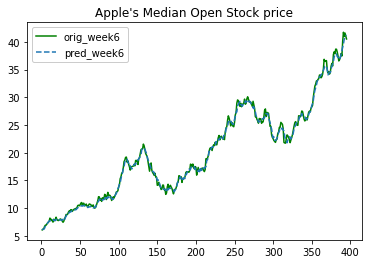

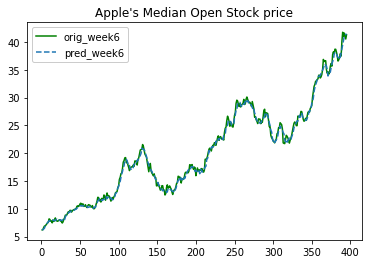

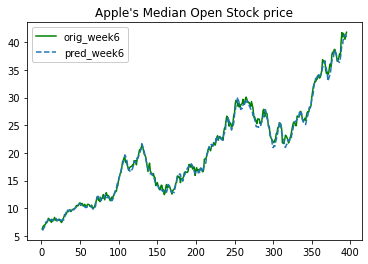

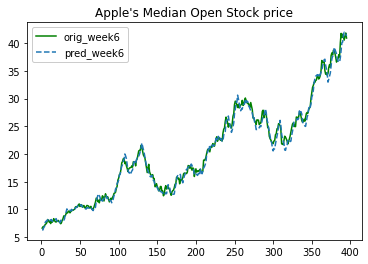

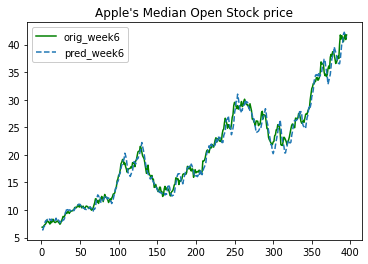

In [39]:
# W6th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 1], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 1], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 2], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 2], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


# W9th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 3], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 3], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 4], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 4], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()



## Need to figure out testing

In [41]:
h = rec.initHidden().to(device)
print(h.shape)
for t_r in reversed(range(test_batch_y.size(1))):
    obs = test_batch_y[:, t_r, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, test_batch_t).permute(1, 0, 2)
test_pred_y = dec(pred_z)[:, batch_time:, :]
print(test_pred_y.shape)

torch.Size([395, 25])
torch.Size([395, 5, 5])


In [48]:
test_pred_y[train_size-test_size:, 4, :].shape

torch.Size([95, 5])

In [47]:
loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, 4, :], label_batch_y[train_size-test_size:, 4, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 51.065120


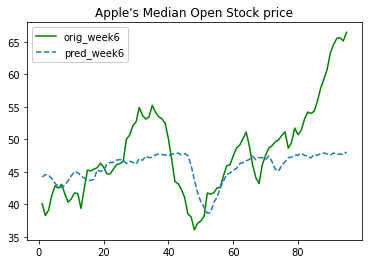

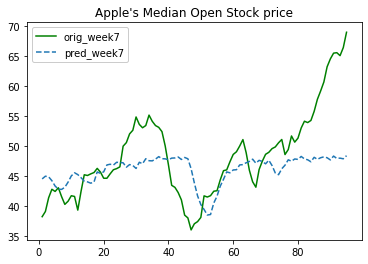

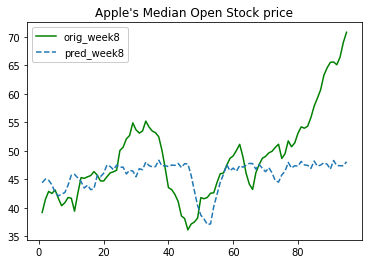

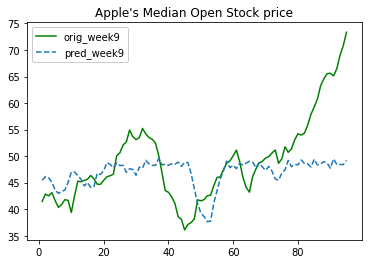

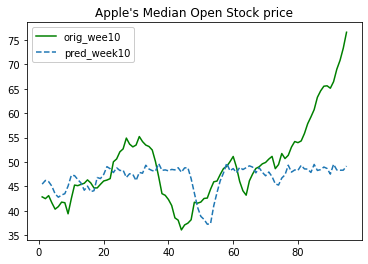

In [49]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time2, test_size-batch_time2)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 2], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


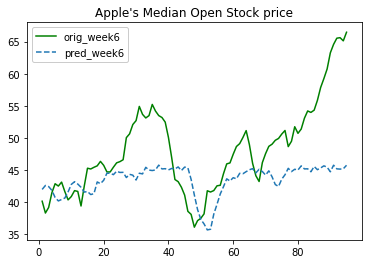

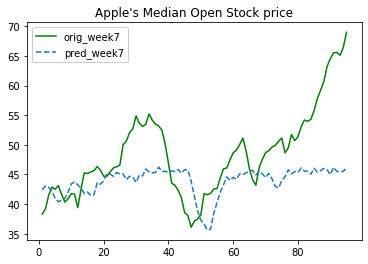

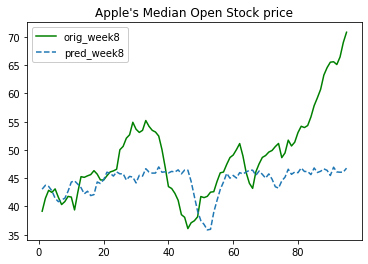

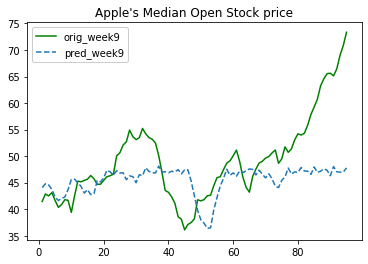

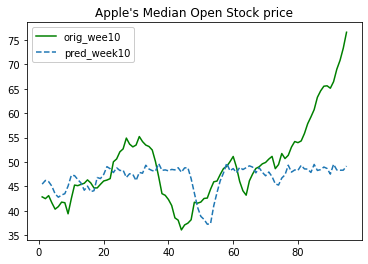

In [50]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time2, test_size-batch_time2)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 0, -1], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 0, -1], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 1, -1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 1, -1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 2, -1], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 2, -1], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 3, -1], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 3, -1], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, -1], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, -1], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


In [56]:
# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, train_size-batch_time).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
lr = 0.001
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    # backward in time to infer q(z_0)
    h = rec.initHidden().to(device)
    for t_r in reversed(range(train_batch_y.size(1))):
        obs = train_batch_y[:, t_r, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # compute loss
#     noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
#     noise_logvar = 2. * torch.log(noise_std_).to(device)
#     logpx = log_normal_pdf(
#         train_batch_y, pred_x, noise_logvar).sum(-1).sum(-1)
#     pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
#     analytic_kl = normal_kl(qz0_mean, qz0_logvar,
#                             pz0_mean, pz0_logvar).sum(-1)
#     loss = torch.mean(-logpx + analytic_kl, dim=0)
    loss = torch.nn.MSELoss()(pred_x[:, 5, :].float(), train_batch_y[:, 5, :].float()).float()
    
    loss.backward()
    optimizer.step()
    loss_meter.update(loss.item())
    if itr%200==0:
        print('Iter: {}, running: {:.4f}'.format(itr, loss.item()))

Iter: 200, running: 6.0155
Iter: 400, running: 1.6814
Iter: 600, running: 1.1198
Iter: 800, running: 0.7970
Iter: 1000, running: 0.6914
Iter: 1200, running: 0.5840
Iter: 1400, running: 0.5161
Iter: 1600, running: 0.4794
Iter: 1800, running: 0.4366
Iter: 2000, running: 0.4569
Iter: 2200, running: 0.4160
Iter: 2400, running: 0.4021
Iter: 2600, running: 0.4075
Iter: 2800, running: 0.3793
Iter: 3000, running: 0.3841
Iter: 3200, running: 0.3671
Iter: 3400, running: 0.3740
Iter: 3600, running: 0.3781
Iter: 3800, running: 0.3809
Iter: 4000, running: 0.3696


In [57]:
h = rec.initHidden().to(device)

for t_r in reversed(range(train_batch_y.size(1))):
    obs = train_batch_y[:, t_r, :]
    out, h = rec.forward(obs, h)
obs = train_batch_y0
out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, train_batch_t).permute(1, 0, 2)
train_pred_y = dec(pred_z)
print(train_pred_y.shape)

torch.Size([395, 6, 5])


In [58]:
loss = torch.nn.MSELoss()(train_pred_y[:, 5, :], train_batch_y[:, 5, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))

Total Loss 1.868026


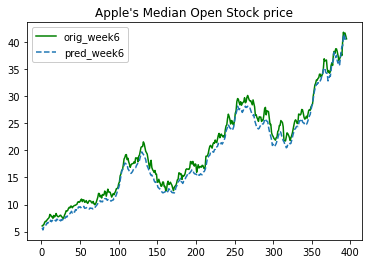

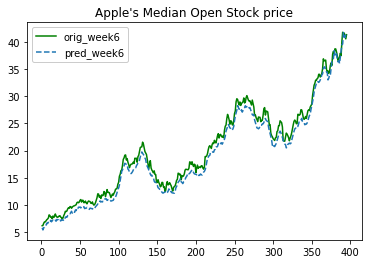

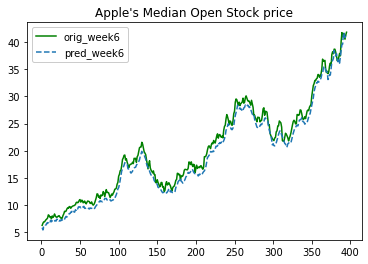

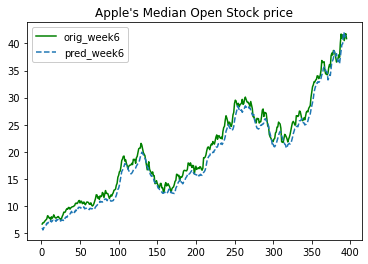

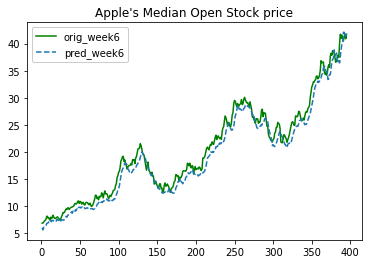

In [59]:
# W6th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 1], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 1], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 2], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 2], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


# W9th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 3], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 3], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., train_size-batch_time, train_size-batch_time)
plt.figure()
plt.plot(t.numpy(), train_batch_y.numpy()[:, 5, 4], 'g', label = 'orig_week6')
plt.plot(t.numpy(), train_pred_y.detach().numpy()[:, 5, 4], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()



torch.Size([395, 25])
torch.Size([395, 5, 5])
Total Loss 568596.555297


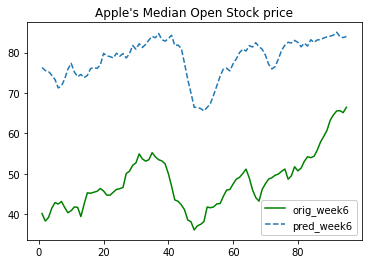

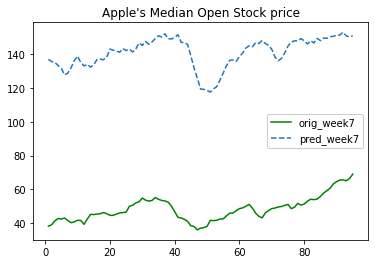

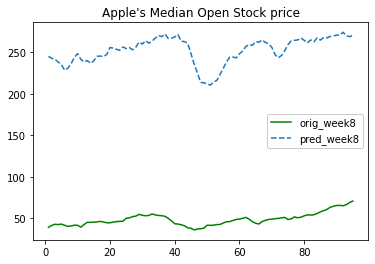

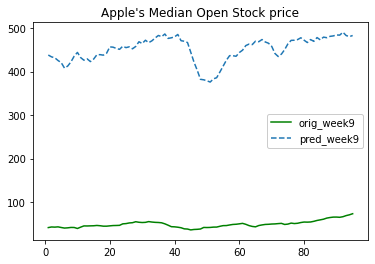

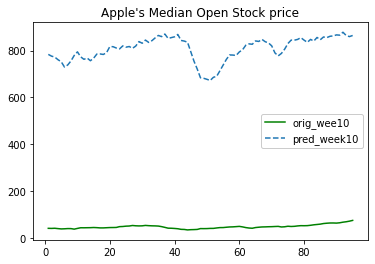

In [60]:
## test
h = rec.initHidden().to(device)
print(h.shape)
for t_r in reversed(range(test_batch_y.size(1))):
    obs = test_batch_y[:, t_r, :]
    out, h = rec.forward(obs, h)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, test_batch_t).permute(1, 0, 2)
test_pred_y = dec(pred_z)[:, batch_time:, :]
print(test_pred_y.shape)

loss = torch.nn.MSELoss()(test_pred_y[train_size-test_size:, 4, :], label_batch_y[train_size-test_size:, 4, :])
with torch.no_grad():
    print('Total Loss {:.6f}'.format(loss.item()))
    
# W6th median prediction
t = torch.linspace(1., test_size-batch_time2, test_size-batch_time2)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 0, -1], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 0, -1], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 1, -1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 1, -1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 2, -1], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 2, -1], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 3, -1], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 3, -1], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, -1], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, -1], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()


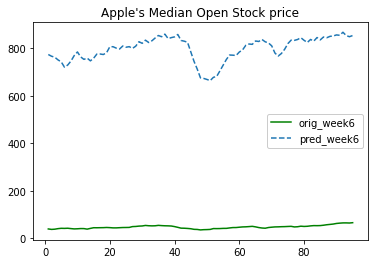

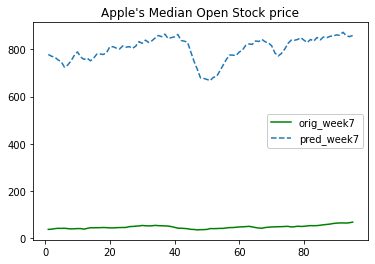

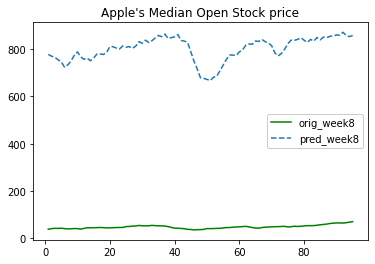

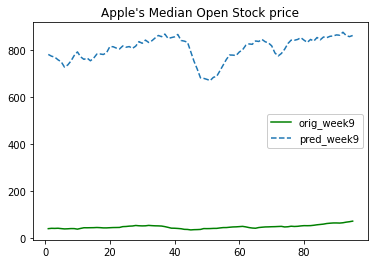

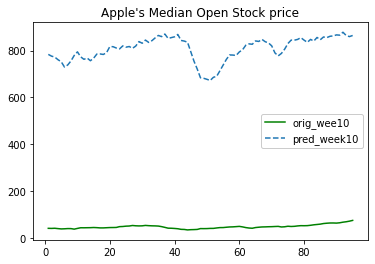

In [61]:
# W6th median prediction
t = torch.linspace(1., test_size-batch_time2, test_size-batch_time2)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 0], 'g', label = 'orig_week6')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 0], '--', label = 'pred_week6')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W7th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 1], 'g', label = 'orig_week7')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 1], '--', label = 'pred_week7')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W8th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 2], 'g', label = 'orig_week8')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 2], '--', label = 'pred_week8')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W9th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 3], 'g', label = 'orig_week9')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 3], '--', label = 'pred_week9')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

# W10th median prediction
t = torch.linspace(1., test_size-batch_time, test_size-batch_time)
plt.figure()
plt.plot(t.numpy(), label_batch_y.numpy()[train_size-test_size:, 4, 4], 'g', label = 'orig_wee10')
plt.plot(t.numpy(), test_pred_y.detach().numpy()[train_size-test_size:, 4, 4], '--', label = 'pred_week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()
